In [1]:
import os
import numpy as np
import pandas as pd
from argparse import ArgumentParser

import random
import patsy as pat
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [2]:
def standardize(mask,data):
    scaler = StandardScaler(with_mean=False, with_std=True)
    scaler.fit(data[mask])
    standardized=scaler.transform(data)
    return standardized

# redefined function from util to only generate standardized betamaps
def case_control(pheno,case,regressors,conn):
    """
    pheno = dataframe:
        -filtered to be only relevant subjects for case control (use mask_cc)
        -case column is onehot encoded
    case = column from pheno
    regressors = list of strings, formatted for patsy
    connectomes = n_subjects x n_edges array
    
    Returns:
    table = n_edges
        - betas_std = including standardization on controls
        - pvalues = pvalues
        - qvalues = fdr corrected pvalues alpha = 0.05
    """
    n_edges = conn.shape[1]

    betas_std = np.zeros(n_edges)

    formula = ' + '.join((regressors + [case]))
    dmat = pat.dmatrix(formula, pheno, return_type='dataframe',NA_action='raise')
    
    mask_std = ~pheno[case].to_numpy(dtype=bool)
    conn_std = standardize(mask_std, conn)
    
    for edge in range(n_edges):
        model_std = sm.OLS(conn_std[:,edge],dmat)
        results_std = model_std.fit()
        betas_std[edge] = results_std.params[case]
    
    table = pd.DataFrame(np.array([betas_std]).transpose(),
                         columns=['betas_std'])
    return table

# Load Data

In [3]:
path_pheno = '/Users/harveyaa/Documents/masters/data/pheno_26-01-22.csv'
pheno = pd.read_csv(path_pheno,index_col=0)
pheno['SEX_01'] = pheno['SEX'].map({'Female':1,'Male':0})

/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_69847/1919533581.py:2: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(path_pheno,index_col=0)


In [4]:
path_conn = '/Users/harveyaa/Documents/masters/data/connectomes_01-12-21.csv'
conn = pd.read_csv(path_conn,index_col=0)

In [5]:
sex_sites = ['SZ3',
        'SZ6',
        'Svip2',
        'ADHD6',
        'HSJ',
        'UCLA_CB',
        'Svip1',
        'UKBB11026',
        'UKBB11027',
        'UKBB11025',
        'ADHD1',
        'ADHD3',
        'ADHD5',
        'UCLA_DS1']

path_ids = '/Users/harveyaa/Documents/masters/neuropsych_mtl/datasets/cv_folds/age_sex/'

In [6]:
site_ids = []
for site in sex_sites:
    if site[:4] == 'UKBB':
        site = site+'_50'
    ids = pd.read_csv(os.path.join(path_ids, f"{site}.csv"),index_col=0).index
    site_ids.append(ids)
site_ids = dict(zip(sex_sites,site_ids))

# Calculate ES (by site)

In [7]:
regressors = ['AGE','FD_scrubbed', 'mean_conn']

sex_mtd = []
for site in sex_sites:
    #regressors = ['AGE','C(SEX)','FD_scrubbed', 'C(SITE)', 'mean_conn']

    pheno.loc[pheno.index.isin(site_ids[site])]
    betamap = case_control(pheno.loc[pheno.index.isin(site_ids[site])],
                'SEX_01',
                regressors,
                conn.loc[conn.index.isin(site_ids[site])].values)['betas_std']

    rank = pd.qcut(betamap.abs(),10,labels=False)
    decile_idx = rank[rank==9].index
    mtd = np.mean(betamap.abs()[decile_idx])
    sex_mtd.append(mtd)
df_mtd = pd.DataFrame(sex_mtd,index=sex_sites,columns=['mtd'])

In [8]:
regressors = ['AGE','FD_scrubbed', 'mean_conn']

cv_es = []
for k in [2,3,5]:
    cc_rows = []
    for site in sex_sites:
        print(site,' ',k)

        idx = site_ids[site]
        strat_col = pheno[pheno.index.isin(idx)]['SEX_01']

        skf = StratifiedKFold(n_splits=k)

        es_train = []
        es_test = []
        k=0
        for train_index, test_index in skf.split(idx, strat_col):
            betamap_train = case_control(pheno.loc[idx[train_index]],
                                            'SEX_01',
                                            regressors,
                                            conn.loc[idx[train_index]].to_numpy())['betas_std']

            rank = pd.qcut(betamap_train.abs(),10,labels=False)
            decile_idx = rank[rank==9].index

            # Get train ES
            decile_train = betamap_train.abs()[decile_idx]
            mtd_train = np.mean(decile_train)
            es_train.append(mtd_train)

            betamap_test = case_control(pheno.loc[idx[test_index]],
                                            'SEX_01',
                                            regressors,
                                            conn.loc[idx[test_index]].to_numpy())['betas_std']
            # Get test ES
            decile_test = betamap_test.abs()[decile_idx]
            mtd_test = np.mean(decile_test)
            es_test.append(mtd_test)

            k += 1

        cc_rows.append([np.mean(es_train),np.mean(es_test)])

    df_cc = pd.DataFrame(cc_rows,columns=[f'train_ES_{k}',f'test_ES_{k}'],index=sex_sites)
    cv_es.append(df_cc)

SZ3   2
SZ6   2
Svip2   2
ADHD6   2
HSJ   2
UCLA_CB   2
Svip1   2
UKBB11026   2
UKBB11027   2
UKBB11025   2
ADHD1   2
ADHD3   2
ADHD5   2
UCLA_DS1   2
SZ3   3
SZ6   3
Svip2   3
ADHD6   3
HSJ   3
UCLA_CB   3
Svip1   3
UKBB11026   3
UKBB11027   3
UKBB11025   3
ADHD1   3
ADHD3   3
ADHD5   3
UCLA_DS1   3
SZ3   5
SZ6   5
Svip2   5
ADHD6   5
HSJ   5
UCLA_CB   5
Svip1   5
UKBB11026   5
UKBB11027   5
UKBB11025   5
ADHD1   5
ADHD3   5
ADHD5   5
UCLA_DS1   5


In [9]:
df_cv = pd.concat(cv_es,axis=1)
df_sex = pd.concat([df_mtd,df_cv],axis=1)
df_sex

,mtd,train_ES_2,test_ES_2,train_ES_3,test_ES_3,train_ES_5,test_ES_5
SZ3,0.791427,1.356545,0.510393,1.005094,0.690770,0.915879,1.852534
SZ6,0.758624,1.145221,0.478483,0.970049,0.620197,0.853729,1.885764
Svip2,0.685457,1.221776,0.382309,0.891568,0.642652,0.791509,1.639178
ADHD6,0.599088,0.927991,0.370444,0.753951,0.530889,0.693937,1.315485
HSJ,0.690813,1.223436,0.430924,1.053833,0.831084,0.818077,2.035909
UCLA_CB,0.621128,1.050324,0.444821,0.768225,0.509303,0.708619,1.373108
Svip1,0.613465,0.929464,0.376173,0.772561,0.548589,0.701571,0.827254
UKBB11026,0.732181,1.105153,0.448075,0.879233,0.530838,0.812413,0.976064
UKBB11027,0.593034,0.808369,0.319811,0.723312,0.458515,0.662032,2.102170
UKBB11025,0.600488,0.902609,0.330084,0.782959,0.503484,0.697336,2.513496


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_69847/2831169558.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_sex.index, rotation=90)


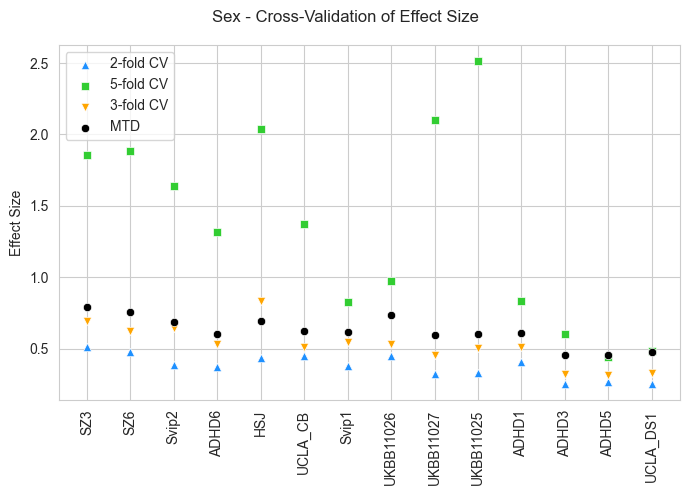

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

colors = ['navy','darkorchid','red','orange','dodgerblue','forestgreen']
colors2 = ['dodgerblue','limegreen','orange','black','forestgreen']

cp = sns.color_palette(colors2)
sns.set_palette(cp)
fig, ax = plt.subplots(figsize=(7,5))
sns.scatterplot(data = df_sex, x = df_sex.index,y = 'test_ES_2',label='2-fold CV',marker='^')
sns.scatterplot(data = df_sex, x = df_sex.index,y = 'test_ES_5',label='5-fold CV',marker='s')
sns.scatterplot(data = df_sex, x = df_sex.index,y = 'test_ES_3',label='3-fold CV',marker='v')
sns.scatterplot(data = df_sex, x = df_sex.index,y = 'mtd',label='MTD')
plt.legend(loc='upper left')
ax.set_xticklabels(df_sex.index, rotation=90)
ax.set_ylabel('Effect Size')
plt.suptitle('Sex - Cross-Validation of Effect Size')
plt.tight_layout()
plt.savefig('./results/sex_effect_size_cv.png',dpi=300)